# Spacecraft with reaction wheels and star tracker

In [3]:
import sympy as sym
import numpy as np
from scipy import linalg
from scipy import signal
from IPython.display import display, Markdown
import ae353_spacecraft_design as design

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

In [4]:
###THIS ENTIRE CELL DEFINES THE SYSTEM'S EOMs AS GIVEN BY THE PROBLEM STATEMENT###
##Wheel and star positions are also defined in this cell##

wheels = [
    {'alpha': np.pi, 'delta': np.pi / 4},
    {'alpha': 3*np.pi / 8, 'delta': 0.},
    {'alpha': -3 * np.pi / 8, 'delta': 0.},
    {'alpha': np.pi, 'delta': -np.pi/4},
]

m, J = design.create_spacecraft(wheels)

stars = [
    {'alpha':  0.10, 'delta':  0},
    {'alpha':  -0.1, 'delta':  0},
    {'alpha':  0, 'delta':  -0.1},
]

design.create_stars(stars)

# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

alpha, delta = sym.symbols('alpha, delta')

# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)



In [8]:
###THIS CELL DEFINES ALL THE NECESSARY MATRICES TO CONTROL AND OBSERVE THE SYSTEM###

f_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f)

psi_e = 0
theta_e = 0
phi_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_1_e = tau_2_e = tau_3_e = tau_4_e = 0

#Validate equilibrium point
f_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

#Define A matrix
A_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([psi, theta, phi, w_x, w_y, w_z]))
A = A_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

#Define B matrix
B_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4], f.jacobian([tau_1, tau_2, tau_3, tau_4]))
B = B_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e, tau_1_e, tau_2_e, tau_3_e, tau_4_e)

print("A matrix:", A.tolist())
print("B matrix:", B.tolist())


#Define G matrix (desired output state of the system)
a1 = 0.1
d1 = 0
a2 = -0.1
d2 = 0
a3 = 0
d3 = -0.1


g1 = g.copy().subs(alpha, a1).subs(delta, d1)
g2 = g.copy().subs(alpha, a2).subs(delta, d2)
g3 = g.copy().subs(alpha, a3).subs(delta, d3)


G = sym.Matrix(np.block([[g1],[g2],[g3]]))


g_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z], G)

print("G matrix:", g_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e).T[0].tolist())


#Define C and D matrices (D is equal to zero)
C_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z], G.jacobian([psi, theta, phi, w_x, w_y, w_z]))
C = C_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e)

D_num = sym.lambdify([psi, theta, phi, w_x, w_y, w_z], G.jacobian([tau_1, tau_2, tau_3, tau_4]))
D_num(psi_e, theta_e, phi_e, w_x_e, w_y_e, w_z_e)

print("C matrix:", sym.Matrix(C).tolist())


#Determine if the system is controllable
n = A.shape[1]
W_c = B
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W_c = np.block([W_c, col])
print("System controllable?", W_c.shape[0] == np.linalg.matrix_rank(W_c))

#Determine if the system is observable
n2 = A.shape[1]
W_o = C
for i in range(1, n2):
    row = C @ np.linalg.matrix_power(A, i)
    W_o = np.block([[W_o], [row]])
print("System observable?", W_o.shape[1] == np.linalg.matrix_rank(W_o))


#Derive K matrix and store controller eigenvalues
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K, P

Q = np.diag([10, 50, 500, 15, 15, 15])
R = 0.005 * np.eye(4) 

K, P = lqr(A, B, Q, R)
print("K matrix:", sym.Matrix(K).tolist())

eigsc = linalg.eigvals(A - B @ K)
sym.Matrix(K)
realc = eigsc.real.tolist()
imagc = eigsc.imag.tolist()


#Derive L matrix and store observer eigenvalues
Qo = np.diag([5, 2, 5, 5, 5, 2])  # trust model less
Ro = np.diag([50, 50, 50, 50, 50, 50])  
L_T, P = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo))
L = L_T.T


eigso = linalg.eigvals(A - L @ C)
#print(eigso)
print("L matrix:", sym.Matrix(L).tolist())
realo = eigso.real.tolist()
imago = eigso.imag.tolist()

A matrix: [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
B matrix: [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.03176262654000795, -0.017189809613852393, -0.017189809613852393, 0.03176262654000795], [-4.164981781442783e-18, -0.0444357585289634, 0.0444357585289634, -4.164981781442783e-18], [-0.029253241023302463, 0.0, 0.0, 0.029253241023302463]]
G matrix: [0.2633785142243077, 0.0, -0.2633785142243077, 0.0, 0.0, -0.26337851422430775]
C matrix: [[-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, -0.263378514224308, 0.0, 0.0, 0.0], [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, 0.263378514224308, 0.0, 0.0, 0.0], [-2.62500000000000, 0.0, -0.263378514224308, 0.0, 0.0, 0.0], [0.0, 2.65142599685905, 0.0, 0.0, 0.0, 0.0]]
System controllable? True
System observable? True
K matrix: [[

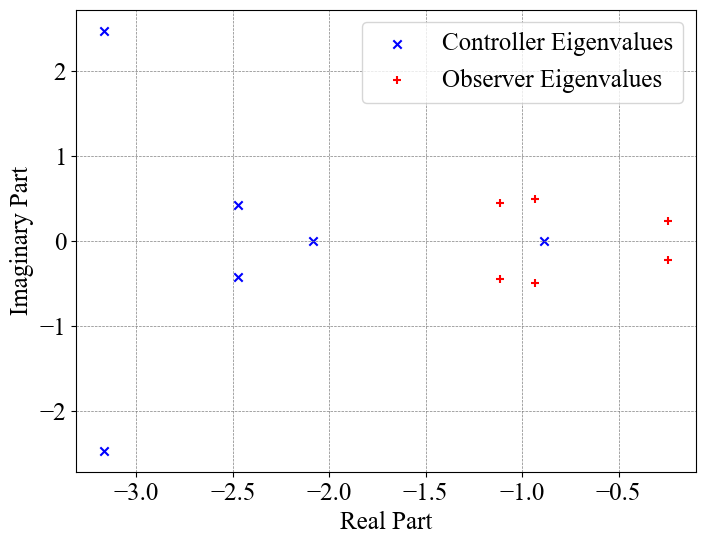

In [9]:
#Plot real and imaginary parts of all eigenvalues
import matplotlib.pyplot as plt
from matplotlib import rcParams


rcParams['font.family'] = 'Times New Roman' 
rcParams['font.size'] = 18

plt.figure(figsize=(8, 6))
plt.scatter(realc, imagc, color='blue', marker='x', label='Controller Eigenvalues')
plt.scatter(realo, imago, color='red', marker='+', label='Observer Eigenvalues')

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("Real Part", )
plt.ylabel("Imaginary Part")
plt.legend()

plt.savefig("eigs.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt

# My own script (an interface to the simulator)
import ae353_spacecraft_simulate

In [13]:
#Define controller with derived matrices and implement state space model with observer and controller

class Controller:
    def __init__(self):
        # FIXME: add class variable names to this list (e.g., 'xhat')
        # if you want these variables to be logged by the simulator
        self.K = np.array([[-31.6227766016837, 2.33688711482298e-13, 196.654402485555, 77.1295374874652, 3.10705835247646e-13, -50.8035509402114], [-1.09793832352081e-13, -70.7106781186551, -106.428595701763, -41.7422048942967, -55.5994716755791, -2.36646474999943e-13], [-2.33214397472203e-14, 70.7106781186546, -106.428595701763, -41.7422048942956, 55.5994716755786, -1.10369407083940e-14], [31.6227766016840, 7.26208156168127e-13, 196.654402485555, 77.1295374874656, 4.59230588785585e-13, 50.8035509402119]], dtype=float)
        
        self.L = np.array([[-0.293234297758717, 0.0170252296157894, -0.293234297758717, -0.0216491318277080, -0.258205613300800, 0.00422489676777777], [-0.0105622419194444, 0.174234597720606, -0.0105622419194444, 0.371285315668559, 0.0216936182105956, 0.162998925187609], [0.323211467065443, -0.526152281382479, 0.323211467065443, 0.674513720025043, -0.674957099984961, -0.129463724220800], [0.0711117560589709, -0.120175998551201, 0.0711117560589709, 0.161383653124438, -0.160508819019237, -0.0280912459832883], [-0.00224389997587119, 0.0977431852009919, -0.00224389997587119, 0.230405790400731, 0.00475455062775376, 0.0959086444296878], [-0.185441795988439, 0.00371415926682769, -0.185441795988439, -0.00484232682082805, -0.176529688691832, 0.000897559990348447]], dtype=float)
        
        self.A = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=float)
        self.B = np.array([[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.03176262654000795, -0.017189809613852393, -0.017189809613852393, 0.03176262654000795], [-4.164981781442783e-18, -0.0444357585289634, 0.0444357585289634, -4.164981781442783e-18], [-0.029253241023302463, 0.0, 0.0, 0.029253241023302463]], dtype=float)
        
        self.C = np.array([[-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, -0.263378514224308, 0.0, 0.0, 0.0], [-2.65142599685905, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 2.62500000000000, 0.263378514224308, 0.0, 0.0, 0.0], [-2.62500000000000, 0.0, -0.263378514224308, 0.0, 0.0, 0.0], [0.0, 2.65142599685905, 0.0, 0.0, 0.0, 0.0]], dtype=float)
        
        self.G = np.array([0.2633785142243077, 0.0, -0.2633785142243077, 0.0, 0.0, -0.26337851422430775], dtype=float)
        
        self.psi_e = 0
        self.theta_e = 0
        self.phi_e = 0
        self.w_x_e = 0
        self.w_y_e = 0
        self.w_z_e = 0
        self.tau_1_e = self.tau_2_e = self.tau_3_e = self.tau_4_e = 0  

        self.dt = 0.01

        self.variables_to_log = ['xhat']
    
    def reset(self):
        self.xhat = np.array([0, 0, 0, 0, 0, 0], dtype=float)

    def run(self, t, star_measurements):
        """
        The variable t is the current time.

        The variable star_measurements is a 1d array of length twice the
        number N of stars:

            [y_1, z_1, y_2, z_2, ..., y_N, z_N]
        
        The image coordinates y_i and z_i of the i'th star (for i = 1, ..., N)
        are at index 2 * i - 2 and 2 * i - 1 of this array, respectively.
        """
        
        
        
        # FIXME: replace the following lines

        u = -self.K @ self.xhat

        torque_1 = u[0] + self.tau_1_e
        torque_2 = u[1] + self.tau_2_e
        torque_3 = u[2] + self.tau_3_e
        torque_4 = u[3] + self.tau_4_e
        
        y = star_measurements - self.G
        #print('measured:', star_measurements)
        #print('equil:', self.G)
        
        self.xhat += self.dt*(self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))


        
        return torque_1, torque_2, torque_3, torque_4
    

In [14]:
#Define a function to run a full simulation with random initial conditions in one cell
def simulate():
    simulator = ae353_spacecraft_simulate.Simulator(
        display=False,
        seed=None,
    )

    controller = Controller()

    simulator.reset(
        initial_conditions=None,
        scope_noise=0.1,        # <-- standard deviation of each image coordinate of each star tracker measurement
        space_debris=True,      # <-- whether or not there is space debris
        docking_time=60.        # <-- how long it takes for the space-cat to dock with the spacecraft
    )

    controller.reset()

    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    dock = 0
    has_docked = simulator.has_docked()
    if has_docked:
        print('The space-cat docked.')
        dock += 1
    else:
        print('The space-cat did not dock.')
        dock += 0
    return dock, data


#Choose number of trials desired to be ran and loop the simulate function while storing data for trials in different lists depending on success or failure
n = 200
success = 0
fail = 0
success_data = []
fail_data = []
for i in range(n):
    print("Trial", i + 1)
    dock, data = simulate()
    if (dock > 0):
        success += 1
        success_data.append(data)
    else:
        fail += 1
        fail_data.append(data)
    print((success/(success+fail))*100, "% success rate")

Trial 1
The space-cat docked.
100.0 % success rate
Trial 2
The space-cat docked.
100.0 % success rate
Trial 3
The space-cat docked.
100.0 % success rate
Trial 4
The space-cat did not dock.
75.0 % success rate
Trial 5
The space-cat docked.
80.0 % success rate
Trial 6
The space-cat did not dock.
66.66666666666666 % success rate
Trial 7
The space-cat docked.
71.42857142857143 % success rate
Trial 8
The space-cat did not dock.
62.5 % success rate
Trial 9
The space-cat did not dock.
55.55555555555556 % success rate
Trial 10
The space-cat docked.
60.0 % success rate
Trial 11
The space-cat did not dock.
54.54545454545454 % success rate
Trial 12
The space-cat docked.
58.333333333333336 % success rate
Trial 13
The space-cat docked.
61.53846153846154 % success rate
Trial 14
The space-cat docked.
64.28571428571429 % success rate
Trial 15
The space-cat docked.
66.66666666666666 % success rate
Trial 16
The space-cat docked.
68.75 % success rate
Trial 17
The space-cat docked.
70.58823529411765 % suc

In [15]:
#Display number of total successes and failures
print(len(success_data))
print(len(fail_data))


###THE FOLLOWING LINES DEFINE A SERIES OF FUNCTIONS TO BE USED LATER IN THE CODE

#Saves data from all trials ran and returns four lists, one for the state error at each timestep for all successful trials, one for the state estimation error
#at each timestep for all successful trials, one for the state error at each timestep for all failed trials, and one for the state estimation error
#at each timestep for all failed trials, 
def save_err_full():
    state_err_s = []
    est_err_s = []
    state_err_f = []
    est_err_f = []
    for data in success_data:
        state = np.array([data['psi'], data['theta'], data['phi'], data['w_x'], data['w_y'], data['w_z']])
        state_err_s.append(state)
        est = np.array(data['xhat']).T
        est_err_s.append(est - state)
    for data in fail_data:
        state = np.array([data['psi'], data['theta'], data['phi'], data['w_x'], data['w_y'], data['w_z']])
        state_err_f.append(state)
        est = np.array(data['xhat']).T
        est_err_f.append(est - state)
    return state_err_s, est_err_s, state_err_f, est_err_f

#Similar to the function above, however, this function only saves the magnitude of the error rather than the error between each individual state. This 
#function also only saves the magnitude of error from successful trials
def save_err():
    state_err = []
    est_err = []
    for data in success_data:
        state = np.linalg.norm(np.array([data['psi'], data['theta'], data['phi'], data['w_x'], data['w_y'], data['w_z']]), axis=0)
        state_err.append(state)
        est = np.linalg.norm(np.array(data['xhat']).T, axis=0)
        est_err.append(est - state)
    return np.array(state_err), np.array(est_err)

#Returns the number of total collisions and the times of all collisions for every successful trial ran
def collision_analysis_s(est_err, trial):
    collisions = 0
    col_times = []
    t = 1
    while t < len(success_data[trial]['t']):
        if (abs(est_err[trial][4][t] - est_err[trial][4][t - 1]) > 0.01):
            collisions += 1
            col_times.append(t/100)
            t += 20
        elif (abs(est_err[trial][3][t] - est_err[trial][3][t - 1]) > 0.01):
            collisions += 1
            col_times.append(t/100)
            t += 20
        elif (abs(est_err[trial][5][t] - est_err[trial][5][t - 1]) > 0.01):
            collisions += 1
            col_times.append(t/100)
            t += 20
        else:
            t += 1
    return collisions, col_times


#Returns the number of total collisions and the times of all collisions for every failed trial ran
def collision_analysis_f(est_err, trial):
    collisions = 0
    col_times = []
    t = 1
    while t < len(fail_data[trial]['t']):
        if (abs(est_err[trial][4][t] - est_err[trial][4][t - 1]) > 0.01):
            collisions += 1
            col_times.append(t/100)
            t += 20
        elif (abs(est_err[trial][3][t] - est_err[trial][3][t - 1]) > 0.01):
            collisions += 1
            col_times.append(t/100)
            t += 20
        elif (abs(est_err[trial][5][t] - est_err[trial][5][t - 1]) > 0.01):
            collisions += 1
            col_times.append(t/100)
            t += 20
        else:
            t += 1
    return collisions, col_times


157
43


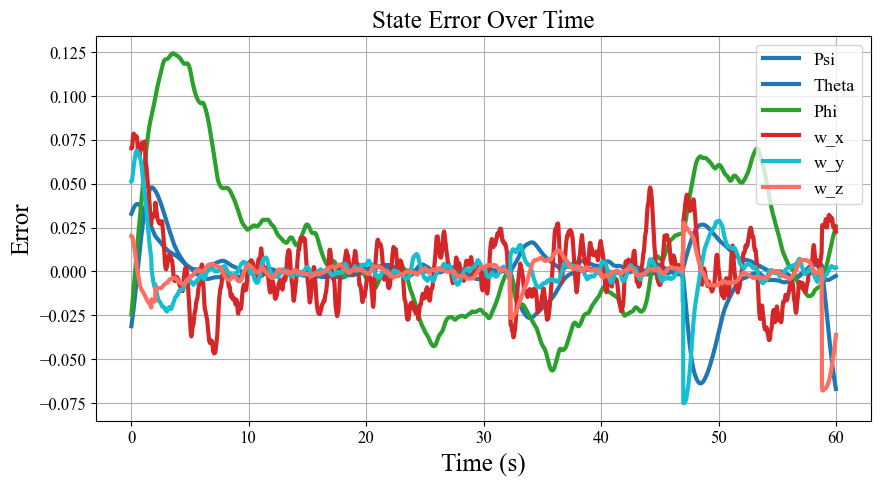

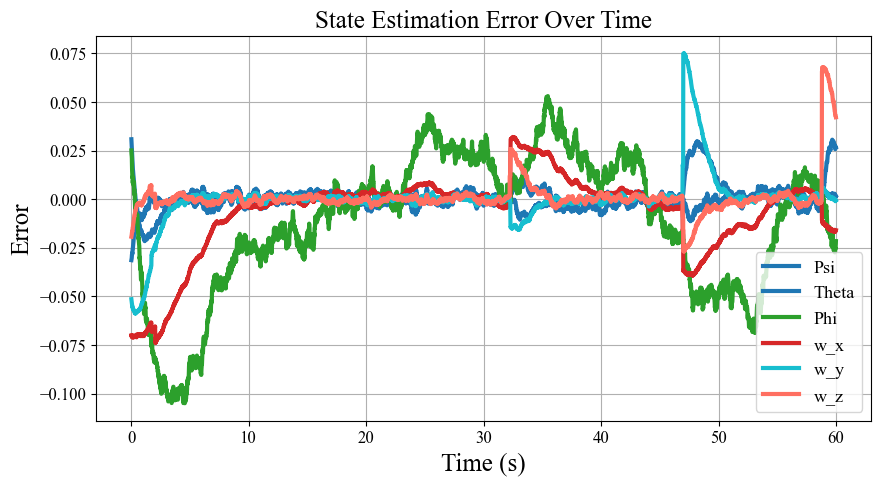

Total collisions: 3
Collision Times: [32.22, 46.94, 58.79]
Total collisions: 5
Collision Times: [2.29, 10.16, 20.48, 40.57, 51.61]


In [335]:
###This cell plots state and state estimation error for each state variable over time for any desired trial, this cell is for viewing purposes only

state_err, est_err, state_err_f, est_err_f = save_err_full()


trial = 0

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

style = ['-', '--', ':', '-.', (0, (5, 10)), (0, (3, 5, 1, 5))]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['t'], state_err[trial][0], label='Psi', linewidth=3, linestyle=style[0], color='#1f77b4')
ax.plot(data['t'], state_err[trial][1], label='Theta', linewidth=3, linestyle=style[0], color='#1f77b4')
ax.plot(data['t'], state_err[trial][2], label='Phi', linewidth=3, linestyle=style[0], color='#2ca02c')
ax.plot(data['t'], state_err[trial][3], label='w_x', linewidth=3, linestyle=style[0], color='#d62728')
ax.plot(data['t'], state_err[trial][4], label='w_y', linewidth=3, linestyle=style[0], color='#17becf')
ax.plot(data['t'], state_err[trial][5], label='w_z', linewidth=3,  linestyle=style[0],color='#ff6f61')
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
ax.set_title('State Error Over Time', fontsize=18)
ax.grid(True)
ax.legend(fontsize=13, loc='upper right')
ax.tick_params(labelsize=12)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['t'], est_err[trial][0], label='Psi', linewidth=3, color='#1f77b4')
ax.plot(data['t'], est_err[trial][1], label='Theta', linewidth=3, color='#1f77b4')
ax.plot(data['t'], est_err[trial][2], label='Phi', linewidth=3, color='#2ca02c')
ax.plot(data['t'], est_err[trial][3], label='w_x', linewidth=3, color='#d62728')
ax.plot(data['t'], est_err[trial][4], label='w_y', linewidth=3, color='#17becf')
ax.plot(data['t'], est_err[trial][5], label='w_z', linewidth=3, color='#ff6f61')
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
ax.set_title('State Estimation Error Over Time', fontsize=18)
ax.grid(True)
ax.legend(fontsize=13, loc='lower right')
ax.tick_params(labelsize=12)
plt.show()


collisions, col_times = collision_analysis_s(est_err, trial)

collisionsf, col_timesf = collision_analysis_f(est_err_f, trial)

print("Total collisions:", collisions)
print("Collision Times:", col_times)
print("Total collisions:", collisionsf)
print("Collision Times:", col_timesf)

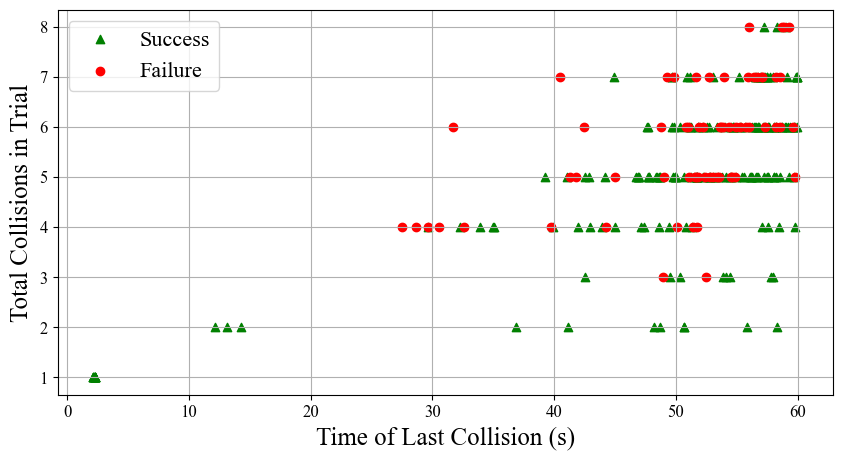

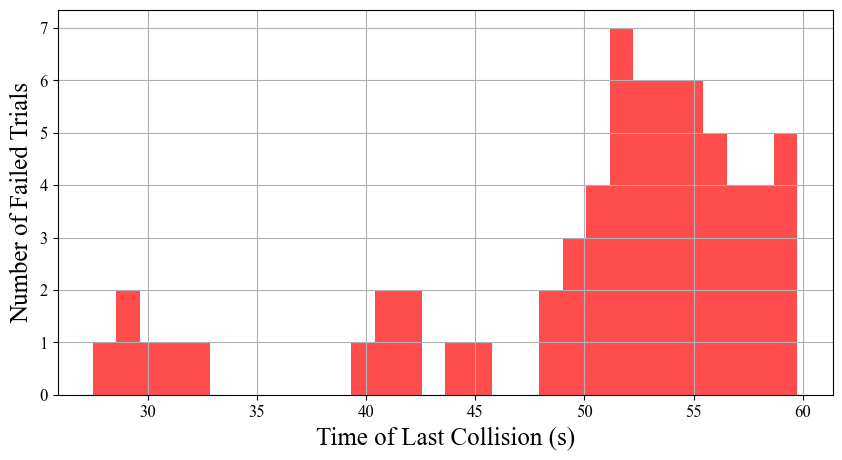

In [380]:
#This cell analyzes collision data for all trials ran and displays information pertaining to the outcome of a trial based on collision times and quantities

state_err, est_err, state_err_f, est_err_f = save_err_full()

cols_s = []
col_t_s = []
cols_f = []
col_t_f = []

for i in range(len(est_err)):
    col, ts = collision_analysis_s(est_err, i)
    cols_s.append(col)
    col_t_s.append(ts[-1])
for i in range(len(est_err_f)):
    col, ts = collision_analysis_f(est_err_f, i)
    cols_f.append(col)
    col_t_f.append(ts[-1])


from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(col_t_s, cols_s, c='g', marker='^', label='Success')
ax.scatter(col_t_f, cols_f, c='r', label='Failure')
ax.set_xlabel('Time of Last Collision (s)', fontsize=18)
ax.set_ylabel('Total Collisions in Trial', fontsize=18)
#ax.set_title('Collision Failure Criteria', fontsize=18)
ax.grid(True)
ax.legend(fontsize=16, loc='upper left')
ax.tick_params(labelsize=12)
plt.show()

import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set Times New Roman font globally
rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10, 5))

# Plot histogram for failed trials based on the time of the last collision
ax.hist(col_t_f, bins=30, color='red', alpha=0.7, label='Failures')

# Label axes and format the plot
ax.set_xlabel('Time of Last Collision (s)', fontsize=18)
ax.set_ylabel('Number of Failed Trials', fontsize=18)
#ax.set_title('Failed Trials Histogram', fontsize=18)
ax.grid(True)
ax.tick_params(labelsize=12)

# Display the histogram
plt.show()

C:\Users\wuert\AppData\Local\Temp\ipykernel_34684\3199561940.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=13, loc='upper right')


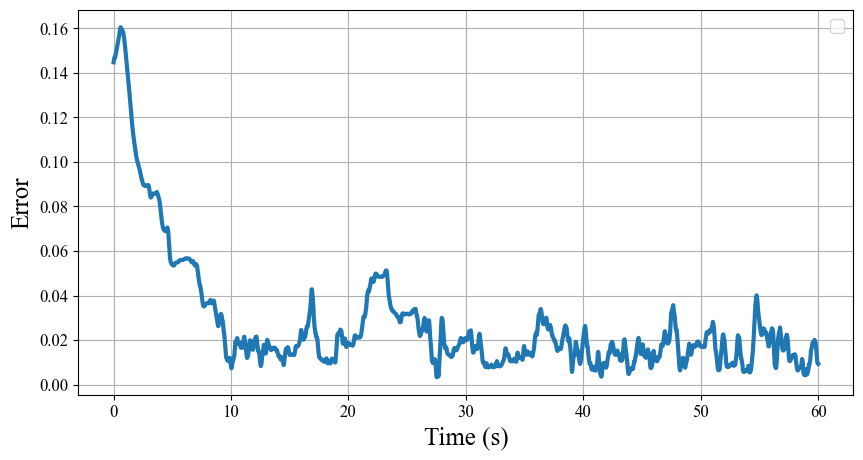

C:\Users\wuert\AppData\Local\Temp\ipykernel_34684\3199561940.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=13, loc='lower right')


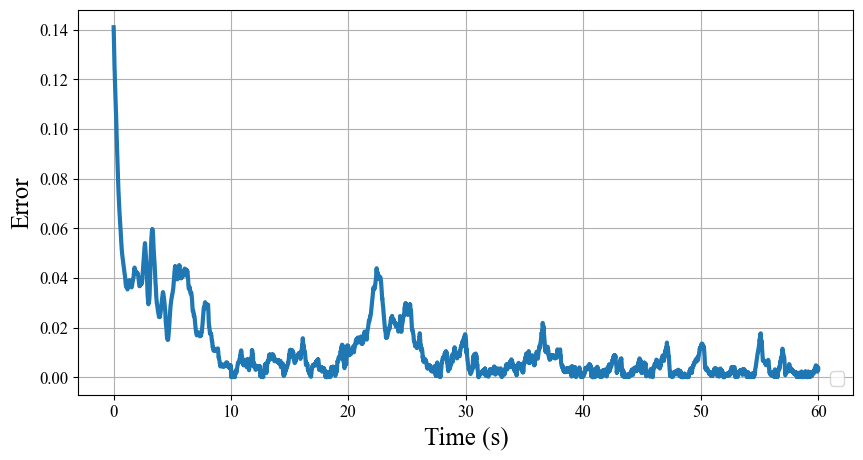

In [359]:
#This cell analyzes trial data (specifically for non-debris trials) to prove convergence toward zero state and state estimation error over time

state_err, est_err = save_err()

trial = 0

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

style = ['-', '--', ':', '-.', (0, (5, 10)), (0, (3, 5, 1, 5))]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['t'], state_err[trial], linewidth=3, linestyle=style[0], color='#1f77b4')
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
#ax.set_title('Magnitude of State Error Over Time', fontsize=18)
ax.grid(True)
ax.legend(fontsize=13, loc='upper right')
ax.tick_params(labelsize=12)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['t'], abs(est_err[trial]), linewidth=3, color='#1f77b4')
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Error', fontsize=18)
#ax.set_title('Magnitude of State Estimation Error Over Time', fontsize=18)
ax.grid(True)
ax.legend(fontsize=13, loc='lower right')
ax.tick_params(labelsize=12)
plt.show()